# **Mercari Price Suggestion Challenge**

1.	Mercari Inc. is a Japanese e-commerce company founded in February 2013. Their main product, the Mercari marketplace app was first launched in Japan in July 2013. This app helps people to sell their unused stuff, or users can simply buy other users’ items - basically a market place.
2.	In this price suggestion challenge, Mercari wants us to build an algorithm that automatically suggests the right product price. The data given to us is the text description of each product that a user has put up for sale. This description includes name or title of the product, product category name, brand name, shipping price included or not, and item condition. Point to be noted is that the users are free to put just about anything, or any bundle of things on the app.


## Link to Kaggle Competetion
This is a [Kaggle competetion](https://www.kaggle.com/c/mercari-price-suggestion-challenge).

## About the dataset
The dataset is taken from the [Mercari Price Suggestion Challenge site](https://www.kaggle.com/c/mercari-price-suggestion-challenge/data) in Kaggle.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pickle

In [2]:
# read dataset

# df_train = pd.read_csv("train.tsv", sep="\t", nrows=10000)
df_train = pd.read_csv("train.tsv", sep="\t")
print(df_train.shape)
df_train.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
# list of columns
df_train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')

__The dataset given to us contains 8 columns:__
1. train_id: Primary id of the listed records
2. name: The title of the product. Here the any possibility of price being displayed is removed. Prices are replaced by \[rm\]
3. item_condition_id: The condition of the items provided by the seller. Although it is not clear until now the interpretation of this id, i.e. order of id.
4. category_name: Category of the listed product
5. brand_name: The name of the brand of the listed product. Some products' brands are not displayed.
6. price: The price at which the product is sold for. This is the target variable and is continuous. The unit is USD.
7. shipping: This is kind of flag. 1 if shipping fee is paid by seller and 0 by buyer.
8. item_description: The full item description of the product by the seller. The data is cleaned to remove any numerical figure suggesting price. The price is replaced by \[rm\]

## Initial observations

In [4]:
#Let's check each column

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


__Observations:__
1. There are null values in _category_name, brand_name,_ and _item_description_ columns.

In [5]:
# number of classes in categorical variables

print(df_train.item_condition_id.value_counts())

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [6]:
print(df_train.category_name.value_counts())

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Home/Home Appliances/Dishwashers                      1
Vintage & Collectibles/Furniture/Shelf                1
Handmade/Woodworking/Supplies                         1
Men/Blazers & Sport Coats/Double Breasted             1
Home/Kids' Home Store/Nursery Furniture               1
Name: category_name, Length: 1287, dtype: int64


In [7]:
print(df_train.brand_name.value_counts())

PINK                    54088
Nike                    54043
Victoria's Secret       48036
LuLaRoe                 31024
Apple                   17322
                        ...  
Woot                        1
Auto Expressions            1
Anita                       1
Natural Expressions         1
Kailijumei Lipsticks        1
Name: brand_name, Length: 4809, dtype: int64


In [8]:
print(df_train.shipping.value_counts())

0    819435
1    663100
Name: shipping, dtype: int64


__Observations:__
1. _category_name_ and _brand_name_ are high cardinal features. _shipping_ and _item_condition_id_ are low cardinal feature.

### price variable

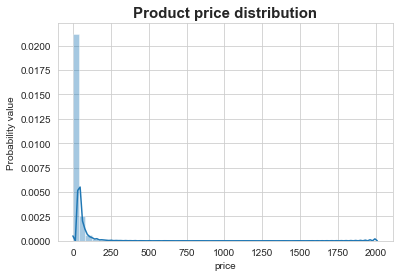

In [9]:
# Let's check the price variable
# https://seaborn.pydata.org/tutorial/distributions.html

sns.set_style('whitegrid')
sns.distplot(df_train['price'], kde=True)
plt.title("Product price distribution",weight='bold').set_fontsize('15' ) 
plt.ylabel("Probability value") 
plt.show()

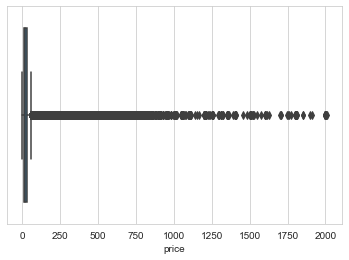

In [10]:
sns.boxplot(x=df_train["price"])
plt.show()

In [11]:
df_train["price"].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Observations:
1. Long tailed distribution. Most data squeezed into low price region.

In [12]:
# Let's generate percentile distribution and see where most of the data lies

x_axis = list(range(0,101,10))
y_axis = []

for p in x_axis:
    y_axis.append(np.percentile(df_train["price"], p))

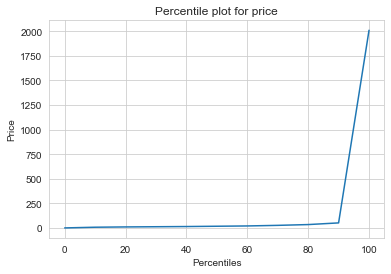

In [13]:
plt.plot(x_axis, y_axis)
plt.title("Percentile plot for price")
plt.xlabel("Percentiles")
plt.ylabel("Price")
plt.show()

In [14]:
# https://datatofish.com/list-to-dataframe/
df_percentile = pd.DataFrame([x_axis,y_axis]).transpose()
df_percentile.columns = ["Percentile","Price"]
df_percentile

,Percentile,Price
0,0.0,0.0
1,10.0,7.0
2,20.0,10.0
3,30.0,12.0
4,40.0,14.0
5,50.0,17.0
6,60.0,20.0
7,70.0,26.0
8,80.0,34.0
9,90.0,51.0


Observations:
1. 90% of price data are less than 51 USD

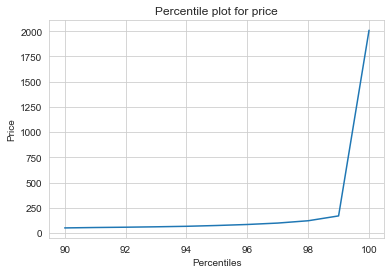

In [15]:
# generating 90-100 percentile distribution
x_axis = list(range(90,101,1))
y_axis = []

for p in x_axis:
    y_axis.append(np.percentile(df_train["price"], p))

plt.plot(x_axis, y_axis)
plt.title("Percentile plot for price")
plt.xlabel("Percentiles")
plt.ylabel("Price")
plt.show()

In [16]:
df_percentile = pd.DataFrame([x_axis,y_axis]).transpose()
df_percentile.columns = ["Percentile","Price"]
df_percentile

,Percentile,Price
0,90.0,51.0
1,91.0,55.0
2,92.0,58.0
3,93.0,62.0
4,94.0,67.0
5,95.0,75.0
6,96.0,85.0
7,97.0,99.0
8,98.0,122.0
9,99.0,170.0


__Observations:__
1. 99% of price data are less than 170 USD.

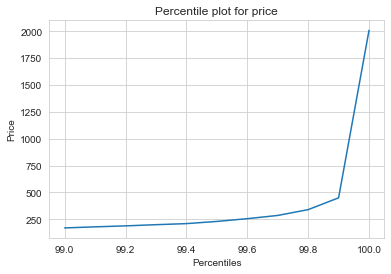

In [17]:
# generating 99-100 percentile distribution
x_axis = list(np.arange(99,100.1,0.1))
y_axis = []

for p in x_axis:
    y_axis.append(np.percentile(df_train["price"], p))

plt.plot(x_axis, y_axis)
plt.title("Percentile plot for price")
plt.xlabel("Percentiles")
plt.ylabel("Price")
plt.show()

In [18]:
df_percentile = pd.DataFrame([x_axis,y_axis]).transpose()
df_percentile.columns = ["Percentile","Price"]
df_percentile

,Percentile,Price
0,99.0,170.00
1,99.1,180.00
2,99.2,189.00
3,99.3,200.00
4,99.4,210.00
5,99.5,230.33
6,99.6,256.00
7,99.7,286.00
8,99.8,340.00
9,99.9,450.00


__Observations:__
1. 99.9% of price data are less than 450 USD.
2. Since the price distribution is skewed, we need to make it close to normal, to prevent any biasing.

In [19]:
# Let's try log transformation to remove the skewness.
#https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45
print("Skewness in price data: ", df_train['price'].skew())
df_train['price_log'] = np.log(df_train['price']+1)
print("After log transform, skewness: ", df_train['price_log'].skew())

Skewness in price data:  11.393232000122524
After log transform, skewness:  0.6594232018807694


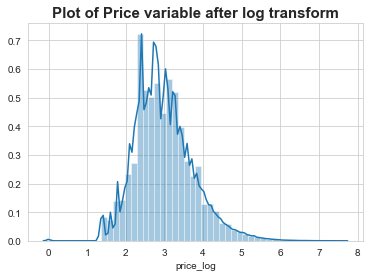

In [20]:
sns.distplot(df_train["price_log"], kde=True)
plt.title('Plot of Price variable after log transform', weight='bold').set_fontsize(15)
plt.show()

Now the distribution looks normal.

### Shipping variable

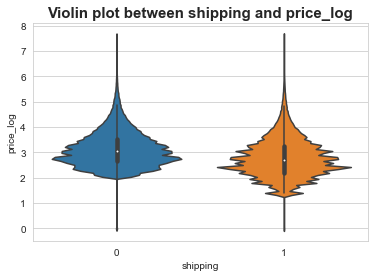

In [21]:
# Let's look at shipping variable
sns.violinplot(x="shipping", y="price_log", data=df_train)
plt.title('Violin plot between shipping and price_log', weight='bold').set_fontsize(15)
plt.show()

Observations:
1. The products for which shipping prince is paid by the seller (_shipping_ = 1) tend to have less selling price.

### item_condition_id

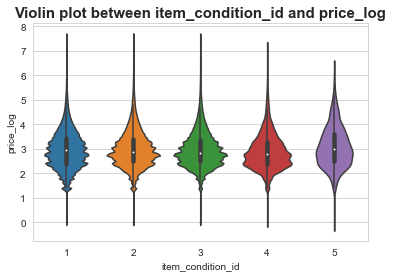

In [22]:
# Let's check the item_condition_id variable

sns.violinplot(x="item_condition_id", y="price_log", data=df_train)
plt.title('Violin plot between item_condition_id and price_log', weight='bold').set_fontsize(15)
plt.show()

In [23]:
#https://stackoverflow.com/questions/33575587/pandas-dataframe-how-to-apply-describe-to-each-group-and-add-to-new-columns
df_cond = df_train.groupby('item_condition_id')['price'].describe().sort_values(by=['50%', 'count'], ascending=False)
df_cond

,count,mean,std,min,25%,50%,75%,max
item_condition_id,,,,,,,,
5,2384.0,31.703859,39.531069,0.0,11.0,19.0,35.25,522.0
1,640549.0,26.486967,35.418024,0.0,10.0,18.0,30.00,2009.0
2,375479.0,27.563225,42.125698,0.0,11.0,17.0,29.00,2004.0
3,432161.0,26.540711,40.030681,0.0,11.0,16.0,28.00,2000.0
4,31962.0,24.349212,35.679148,0.0,10.0,15.0,26.00,1309.0


In [24]:
#https://stackoverflow.com/questions/33575587/pandas-dataframe-how-to-apply-describe-to-each-group-and-add-to-new-columns
df_cond = df_train.groupby('item_condition_id')['price_log'].describe().sort_values(by=['50%', 'count'], ascending=False)
df_cond

,count,mean,std,min,25%,50%,75%,max
item_condition_id,,,,,,,,
5,2384.0,3.092496,0.830604,0.0,2.484907,2.995732,3.590369,6.259581
1,640549.0,2.972679,0.766628,0.0,2.397895,2.944439,3.433987,7.605890
2,375479.0,3.000738,0.746726,0.0,2.484907,2.890372,3.401197,7.603399
3,432161.0,2.975196,0.725443,0.0,2.484907,2.833213,3.367296,7.601402
4,31962.0,2.896014,0.725102,0.0,2.397895,2.772589,3.295837,7.177782


In [25]:
print(df_train.item_condition_id.value_counts(normalize=True))

1    0.432063
3    0.291501
2    0.253268
4    0.021559
5    0.001608
Name: item_condition_id, dtype: float64


__Observations:__
1. Condition label 5 tend to have high price.
2. Most of the products have _item_condition_ = 1
3. _item_condition_ with value 5 are very less in number.

### Category_name

In [26]:
# the category_name variable contains categories separated by '/'
# so we split this into categories ['category1', 'category2', 'category3',...]

#https://www.geeksforgeeks.org/split-a-text-column-into-two-columns-in-pandas-dataframe/
#https://stackoverflow.com/questions/46585193/pandas-error-in-python-columns-must-be-same-length-as-key

num_cat = 50 #assuming maximum possible subcategories is 50
# df_train['no_of_categories'] = df_train['category_name'].str.split(pat="/", n=num_cat, expand=False).apply(lambda x: len(x))
temp = df_train['category_name'].str.split(pat="/", n=num_cat, expand=True)
temp.columns = ['category{}'.format(x+1) for x in temp.columns]
temp.head()

,category1,category2,category3,category4,category5
0,Men,Tops,T-shirts,None,None
1,Electronics,Computers & Tablets,Components & Parts,None,None
2,Women,Tops & Blouses,Blouse,None,None
3,Home,Home Décor,Home Décor Accents,None,None
4,Women,Jewelry,Necklaces,None,None


In [27]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_log
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662


Only 5 categories are present

In [28]:
df_train = df_train.join(temp)
print(df_train.shape)
df_train.head()

(1482535, 14)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_log,category1,category2,category3,category4,category5
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,None,None
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,None,None
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,None,None
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,None,None
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,None,None


In [29]:
df_train.drop(columns="category_name", inplace=True)
print(df_train.shape)

(1482535, 13)


In [30]:
df_train[['category1','category2','category3','category4','category5']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 5 columns):
category1    1476208 non-null object
category2    1476208 non-null object
category3    1476208 non-null object
category4    4389 non-null object
category5    3059 non-null object
dtypes: object(5)
memory usage: 56.6+ MB


There are many NULL values in the columns. Let's treat them

In [31]:
df_train["category1"] = df_train["category1"].apply(lambda x: "No category" if (x is None) or (x is np.nan) else x)
df_train["category2"] = df_train["category2"].apply(lambda x: "No category" if (x is None) or (x is np.nan) else x)
df_train["category3"] = df_train["category3"].apply(lambda x: "No category" if (x is None) or (x is np.nan) else x)
df_train["category4"] = df_train["category4"].apply(lambda x: "No category" if (x is None) or (x is np.nan) else x)
df_train["category5"] = df_train["category5"].apply(lambda x: "No category" if (x is None) or (x is np.nan) else x)

In [32]:
print(df_train[['category1','category2','category3','category4','category5']].info())
print(df_train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 5 columns):
category1    1482535 non-null object
category2    1482535 non-null object
category3    1482535 non-null object
category4    1482535 non-null object
category5    1482535 non-null object
dtypes: object(5)
memory usage: 56.6+ MB
None
(1482535, 13)


In [33]:
df_train.category1.value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
No category                 6327
Name: category1, dtype: int64

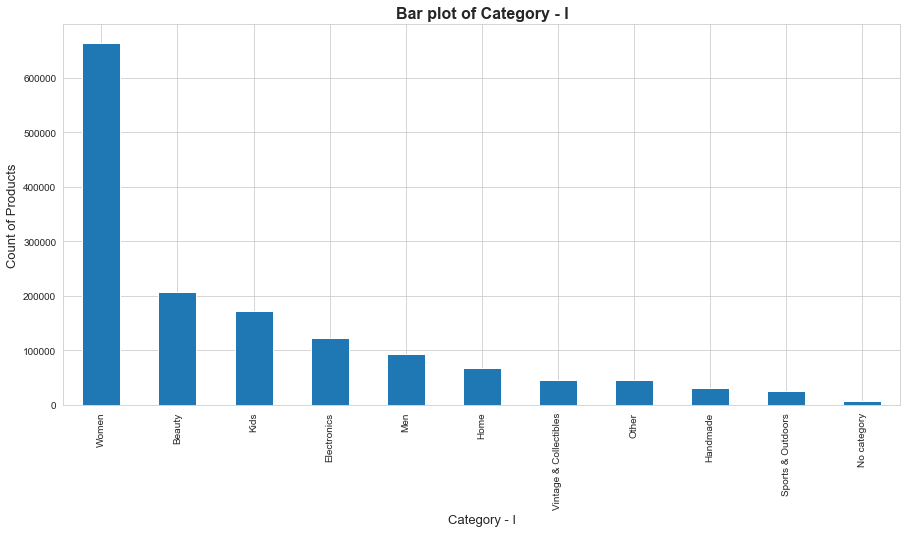

In [34]:
df_train.category1.value_counts().plot(kind='bar', figsize=(15,7))
plt.title("Bar plot of Category - I", weight='bold').set_fontsize(16)
plt.xlabel("Category - I").set_fontsize(13)
plt.ylabel("Count of Products").set_fontsize(13)
plt.show()

__Observations:__
1. Most of the products are for Women.

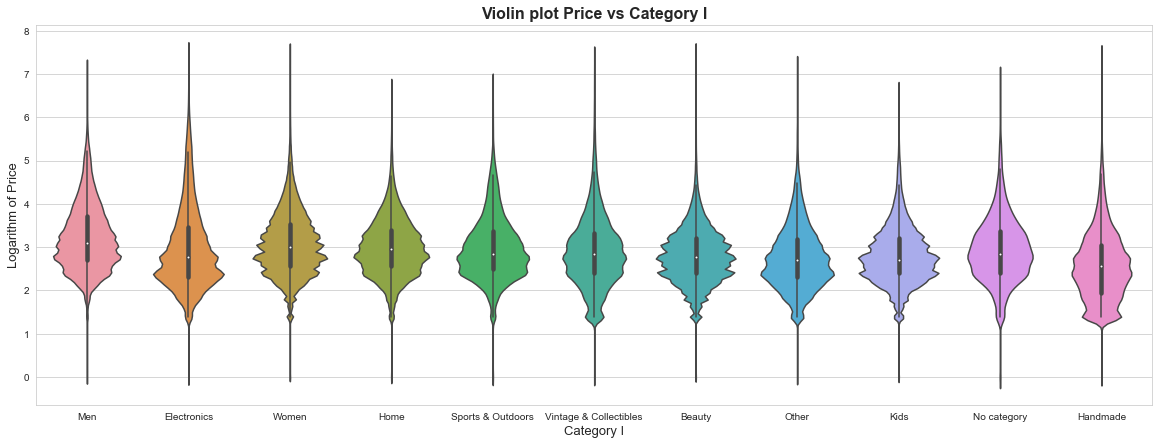

In [35]:
#https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,7))
sns.violinplot(ax=ax, x="category1", y="price_log", data=df_train)
plt.title("Violin plot Price vs Category I", weight='bold').set_fontsize(16)
plt.xlabel("Category I").set_fontsize(13)
plt.ylabel("Logarithm of Price").set_fontsize(13)
plt.show()

In [36]:
#https://stackoverflow.com/questions/33575587/pandas-dataframe-how-to-apply-describe-to-each-group-and-add-to-new-columns
df_cat1 = df_train.groupby('category1')['price'].describe().sort_values(by=['50%', 'count'], ascending=False)
df_cat1

,count,mean,std,min,25%,50%,75%,max
category1,,,,,,,,
Men,93680.0,34.708614,41.240057,0.0,14.0,21.0,40.0,1309.0
Women,664385.0,28.885496,39.443853,0.0,12.0,19.0,33.0,2009.0
Home,67871.0,24.536599,24.417061,0.0,12.0,18.0,29.0,848.0
Vintage & Collectibles,46530.0,27.339426,53.507495,0.0,10.0,16.0,27.0,1709.0
Sports & Outdoors,25342.0,25.532219,29.302234,0.0,11.0,16.0,28.0,915.0
No category,6327.0,25.394658,34.114422,0.0,10.0,16.0,28.0,1000.0
Beauty,207828.0,19.671536,21.360135,0.0,10.0,15.0,24.0,2000.0
Electronics,122690.0,35.173922,65.419784,0.0,9.0,15.0,31.0,1909.0
Kids,171689.0,20.642315,22.730876,0.0,10.0,14.0,24.0,809.0


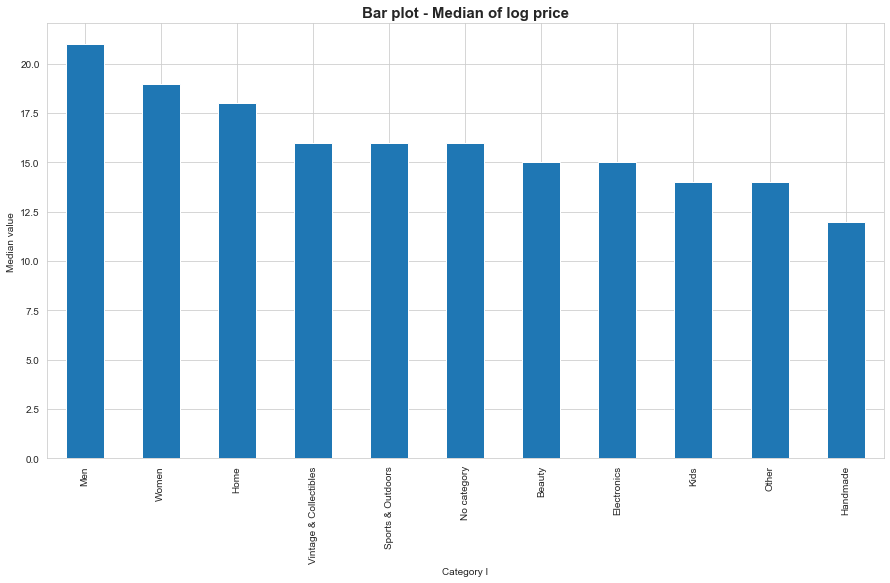

In [37]:
df_cat1.loc[:,'50%'].plot(kind='bar', figsize=(15,8))
plt.title('Bar plot - Median of log price', weight='bold').set_fontsize(15)
plt.xlabel('Category I')
plt.ylabel('Median value')
plt.show()

__Observations:__
1. Men products tend to have high median value. This suggests that Men products are costlier than other products. Whereas, Handmade and Kids products have the least median price value.

In [38]:
df_train.category2.value_counts()

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: category2, Length: 114, dtype: int64

In [39]:
df_cat2 = df_train.groupby('category2')['price'].describe().sort_values(by=['50%', 'count'], ascending=False)
df_cat2.head()

,count,mean,std,min,25%,50%,75%,max
category2,,,,,,,,
Computers & Tablets,7439.0,87.887754,138.997975,0.0,19.0,40.0,97.0,1900.0
Cameras & Photography,3976.0,71.343813,96.705241,0.0,19.0,40.0,75.0,1056.0
Strollers,477.0,67.280922,84.207606,3.0,18.0,36.0,76.0,590.0
Women's Handbags,45862.0,58.201648,96.200972,0.0,18.0,31.0,65.0,2009.0
Musical instruments,1032.0,46.684109,60.310585,0.0,14.0,30.5,59.0,900.0


In [40]:
df_cat2.tail()

,count,mean,std,min,25%,50%,75%,max
category2,,,,,,,,
Children,1242.0,12.664251,13.630351,3.0,7.0,9.0,13.0,175.0
Magazines,219.0,12.200913,9.150415,3.0,7.0,9.0,15.0,60.0
Trading Cards,6483.0,14.788678,24.073401,0.0,4.0,8.0,16.0,500.0
Quilts,31.0,12.258065,12.143497,3.0,5.0,8.0,15.5,59.0
Paper Goods,6208.0,10.774323,18.739069,0.0,4.0,6.0,11.0,334.0


In [41]:
lst = list(df_cat2.iloc[:5].index)
lst.extend(list(df_cat2.iloc[-5:].index))
lst

['Computers & Tablets',
 'Cameras & Photography',
 'Strollers',
 "Women's Handbags",
 'Musical instruments',
 'Children',
 'Magazines',
 'Trading Cards',
 'Quilts',
 'Paper Goods']

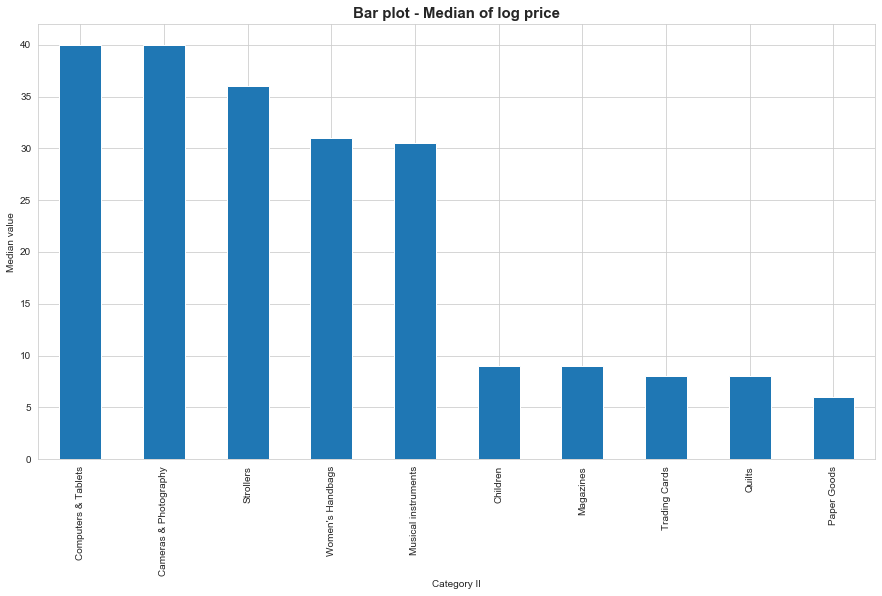

In [42]:
df_cat2.loc[lst,'50%'].plot(kind='bar', figsize=(15,8))
plt.title('Bar plot - Median of log price', weight='bold').set_fontsize(15)
plt.xlabel('Category II')
plt.ylabel('Median value')
plt.show()

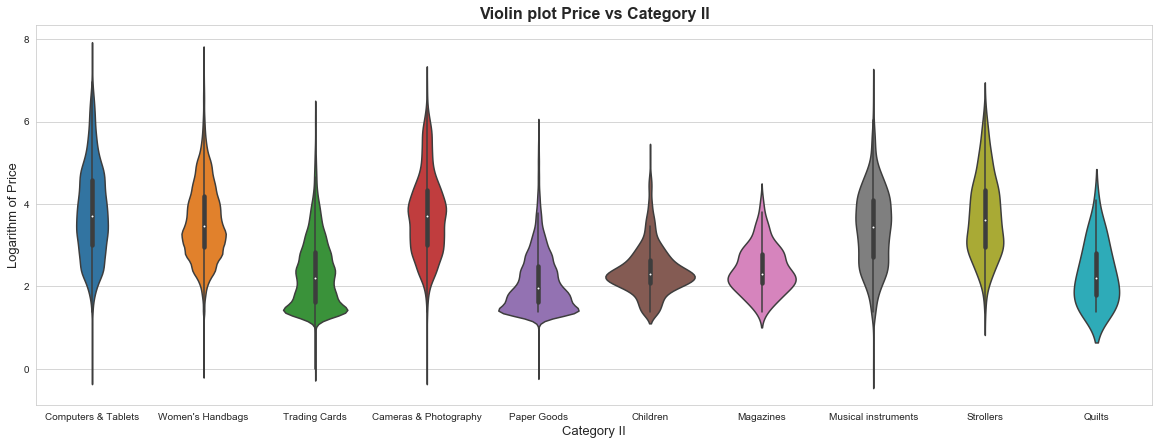

In [43]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(20,7))
sns.violinplot(ax=ax, x="category2", y="price_log", data=df_train[df_train['category2'].isin(lst)])
plt.title("Violin plot Price vs Category II", weight='bold').set_fontsize(16)
plt.xlabel("Category II").set_fontsize(13)
plt.ylabel("Logarithm of Price").set_fontsize(13)
plt.show()

__Observations:__
1. Electronic gadgets like Computers, Tablets, Cameras, etc. have high price compared to other products. Whereas, products related to Children, Magazines, Trading Cards, Quilts, and Paper goods have less price.

In [44]:
df_train.category3.value_counts()

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Cuff                           1
Decorating                     1
Pad                            1
Videogame                      1
Crib Netting                   1
Name: category3, Length: 871, dtype: int64

In [45]:
df_cat3 = df_train.groupby('category3')['price'].describe().sort_values(by=['50%', 'count'], ascending=False)
df_cat3.head()

,count,mean,std,min,25%,50%,75%,max
category3,,,,,,,,
Standard,15.0,163.666667,133.830205,19.0,57.50,145.0,255.0,480.0
Air Conditioners,42.0,121.142857,58.600579,9.0,81.25,131.0,176.0,186.0
Lightweight,18.0,117.111111,88.994308,17.0,47.25,105.0,152.5,385.0
Laptops & Netbooks,1783.0,177.089176,214.583622,3.0,40.00,100.0,215.0,1708.0
Women's Golf Clubs,4.0,85.750000,54.548908,8.0,73.25,100.0,112.5,135.0


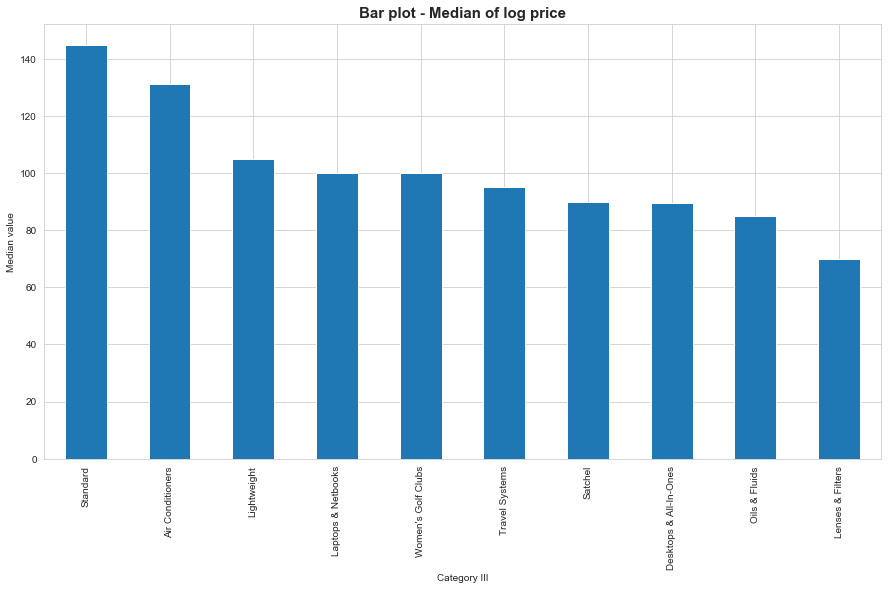

In [46]:
df_cat3.head(10).loc[:,'50%'].plot(kind='bar', figsize=(15,8))
plt.title('Bar plot - Median of log price', weight='bold').set_fontsize(15)
plt.xlabel('Category III')
plt.ylabel('Median value')
plt.show()

In [47]:
df_cat3.tail()

,count,mean,std,min,25%,50%,75%,max
category3,,,,,,,,
Patch,829.0,5.560917,3.742976,3.0,3.0,5.0,6.0,40.0
Bookmark,15.0,9.066667,9.505387,3.0,3.5,5.0,8.5,34.0
Artist Bears,1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
Mirror,1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
Sticker,4117.0,6.069711,5.780126,3.0,3.0,4.0,6.0,150.0


In [48]:
lst = list(df_cat3.iloc[:5].index)
lst.extend(list(df_cat3.iloc[-5:].index))
lst

['Standard',
 'Air Conditioners',
 'Lightweight',
 'Laptops & Netbooks',
 "Women's Golf Clubs",
 'Patch',
 'Bookmark',
 'Artist Bears',
 'Mirror',
 'Sticker']

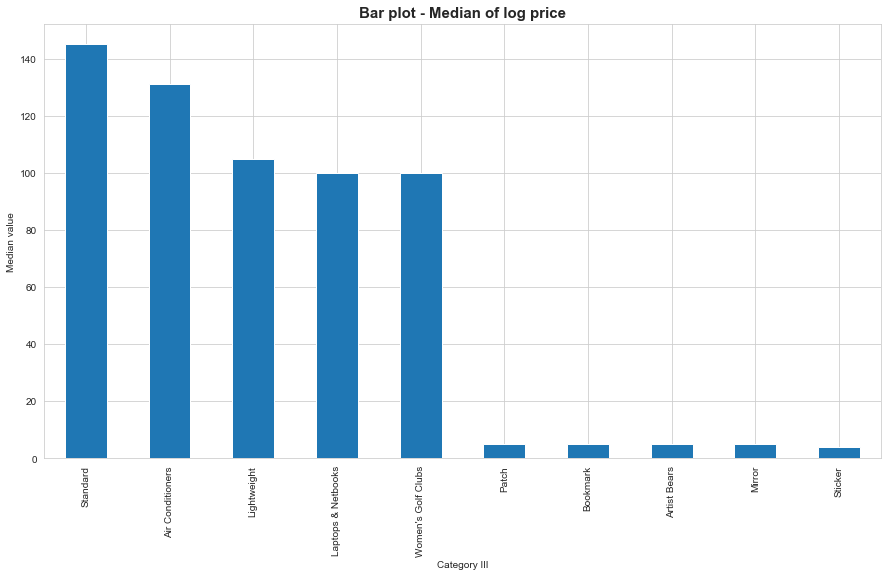

In [49]:
df_cat3.loc[lst,'50%'].plot(kind='bar', figsize=(15,8))
plt.title('Bar plot - Median of log price', weight='bold').set_fontsize(15)
plt.xlabel('Category III')
plt.ylabel('Median value')
plt.show()

__Observations:__
1. Standard category products, Air Conditioners have high median price, whereas Mirror, Sticker, Artist Bears, Bookmark have low price.

# brand_name

In [50]:
df_train.brand_name.isna().sum()

632682

In [51]:
df_train.brand_name.fillna("missing", inplace=True)
df_train.brand_name.isna().sum()

0

In [52]:
df_train.brand_name.value_counts()

missing                 632682
PINK                     54088
Nike                     54043
Victoria's Secret        48036
LuLaRoe                  31024
                         ...  
Winner's Circle              1
DDF                          1
Kikit                        1
Eclectic Products            1
Kailijumei Lipsticks         1
Name: brand_name, Length: 4810, dtype: int64

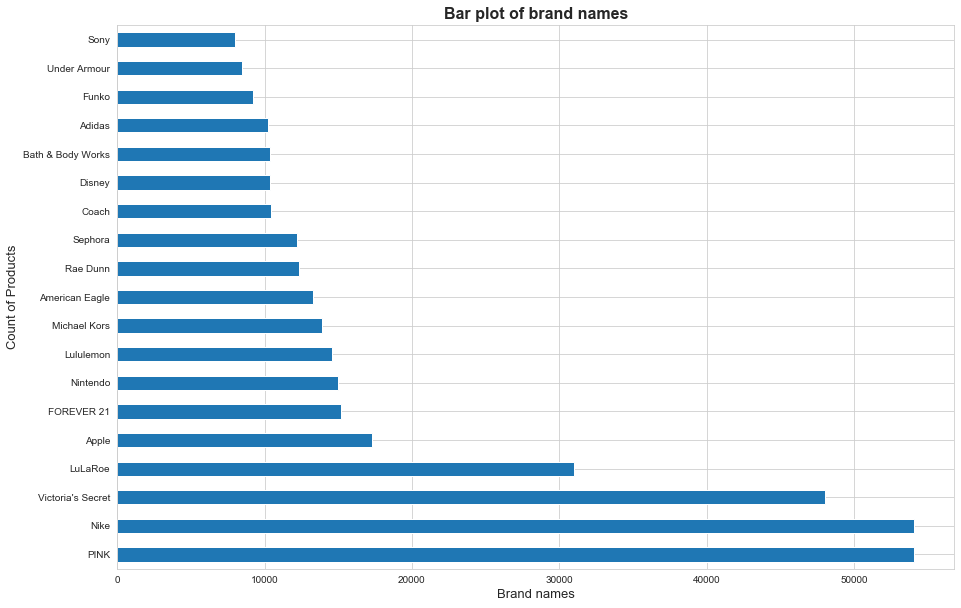

In [53]:
#https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html
df_train.brand_name.value_counts()[1:20].plot(kind='barh', figsize=(15,10))
plt.title("Bar plot of brand names", weight='bold').set_fontsize(16)
plt.ylabel("Count of Products").set_fontsize(13)
plt.xlabel("Brand names").set_fontsize(13)
plt.show()

Most products do not have any brand mentioned. Leaving the 'unbranded products', __PINK__ is the brand mentioned the most, followed by __Nike__.

In [54]:
df_brand = df_train.groupby('brand_name')['price'].describe().sort_values(by=['50%', 'count'], ascending=False)
df_brand.head()

,count,mean,std,min,25%,50%,75%,max
brand_name,,,,,,,,
Demdaco,2.0,429.00,592.555483,10.0,219.50,429.0,638.5,848.0
Auto Meter,1.0,344.00,NaN,344.0,344.00,344.0,344.0,344.0
Proenza Schouler,4.0,413.25,420.369183,16.0,217.75,315.5,511.0,1006.0
Oris,1.0,300.00,NaN,300.0,300.00,300.0,300.0,300.0
Longines,1.0,254.00,NaN,254.0,254.00,254.0,254.0,254.0


In [55]:
df_brand.tail()

,count,mean,std,min,25%,50%,75%,max
brand_name,,,,,,,,
Revlon Colorsilk,1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
Scunci,1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
Twilight Gypsy Collective,1.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0
CM Style Fashion,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
Gossip Girl,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [56]:
df_brand = df_brand[df_brand['count']>=10]
df_brand.head(10)

,count,mean,std,min,25%,50%,75%,max
brand_name,,,,,,,,
David Yurman,242.0,248.611570,190.054736,7.0,170.00,220.0,300.00,2004.0
Alexander Wang,37.0,205.702703,132.034268,15.0,86.00,200.0,271.00,489.0
Balenciaga,63.0,185.444444,148.766084,14.0,83.00,176.0,233.00,959.0
Canada Goose,16.0,230.250000,181.463495,8.0,109.00,171.5,340.25,608.0
Christian Louboutin,360.0,188.444444,142.998850,9.0,70.75,156.0,299.25,650.0
Tieks,61.0,152.950820,43.067167,29.0,144.00,156.0,171.00,245.0
Céline,16.0,165.375000,179.071634,10.0,56.75,153.0,183.50,759.0
Sherri Hill,213.0,169.657277,116.317027,5.0,79.00,151.0,234.00,999.0
Celine,73.0,238.780822,339.356795,12.0,65.00,149.0,239.00,1806.0


In [57]:
lst = list(df_brand.iloc[:20].index)
lst

['David Yurman',
 'Alexander Wang',
 'Balenciaga',
 'Canada Goose',
 'Christian Louboutin',
 'Tieks',
 'Céline',
 'Sherri Hill',
 'Celine',
 'Jovani',
 'Nest',
 'MICHELE',
 'Go Gear',
 'MCM Worldwide',
 'Stuart Weitzman',
 'Giuseppe Zanotti',
 'Spell & The Gypsy Collective',
 'Galaxy',
 'Spin Master',
 'Hoverboard']

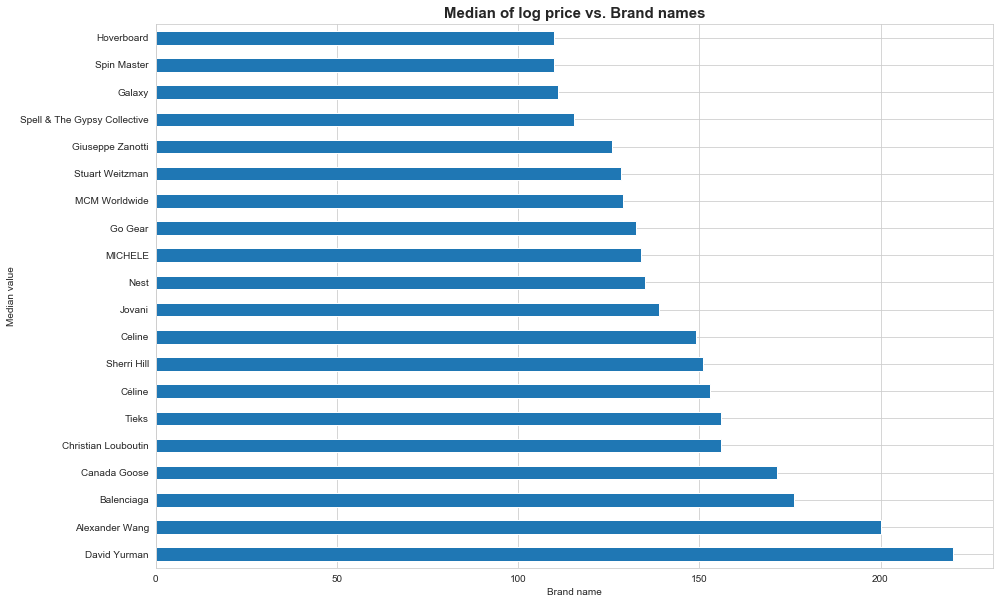

In [58]:
df_brand.loc[lst,'50%'].plot(kind='barh', figsize=(15,10))
plt.title('Median of log price vs. Brand names', weight='bold').set_fontsize(15)
plt.xlabel('Brand name')
plt.ylabel('Median value')
plt.show()

__Observations:__
1. Although some brands have high median price value, but their count is very low.

### Item_description

In [59]:
df_train.item_description.isna().sum()

4

Only 4 rows are there with NULL values. We can drop those rows.

In [60]:
df_train.dropna(inplace=True)

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482531 entries, 0 to 1482534
Data columns (total 13 columns):
train_id             1482531 non-null int64
name                 1482531 non-null object
item_condition_id    1482531 non-null int64
brand_name           1482531 non-null object
price                1482531 non-null float64
shipping             1482531 non-null int64
item_description     1482531 non-null object
price_log            1482531 non-null float64
category1            1482531 non-null object
category2            1482531 non-null object
category3            1482531 non-null object
category4            1482531 non-null object
category5            1482531 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 158.4+ MB


## Preprocess and Feature Engineering

We have already done somewhat feature engineering on _category_ feature. Let's try with other columns.

Let's take length of _name_ and length of _item_description,_ and see if there is any relationship with _price._

In [62]:
df_train['name_len'] = df_train['name'].apply(lambda x: len(x))
df_train['desc_len'] = df_train['item_description'].apply(lambda x: len(x))
df_train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,price_log,category1,category2,category3,category4,category5,name_len,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,No category,No category,35,18
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,No category,No category,32,188
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,No category,No category,14,124
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,No category,No category,21,173
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,No category,No category,20,41


In [63]:
len(df_train[df_train['item_description']=='No description yet']) / len(df_train)

0.0556406577670214

In [64]:
min(df_train['desc_len'])

1

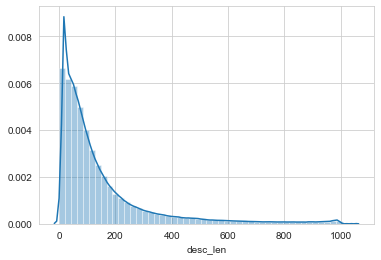

In [65]:
sns.distplot(df_train['desc_len'], kde=True)

In [66]:
print(df_train['price'].corr(df_train['desc_len']))
print(df_train['price_log'].corr(df_train['desc_len']))

0.04804841099869324
0.030198007624486285


Not much correlation

In [67]:
df_train.drop(columns='desc_len', inplace=True)

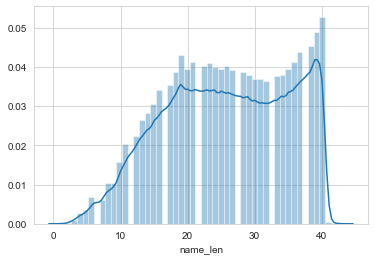

In [68]:
sns.distplot(df_train['name_len'], kde=True)
plt.show()

In [69]:
print(df_train['price'].corr(df_train['name_len']))
print(df_train['price_log'].corr(df_train['name_len']))

0.027069385094117118
0.0467145769004389


Not much correlation

In [70]:
df_train.drop(columns='name_len', inplace=True)

### Branded and not branded

Let's create a feature flag. This will contain whether the product is branded or not.

In [71]:
df_train['branded'] = df_train['brand_name'].apply(lambda x: 0 if(x=='missing') else 1)
df_train.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,price_log,category1,category2,category3,category4,category5,branded
0,0,MLB Cincinnati Reds T Shirt Size XL,3,missing,10.0,1,No description yet,2.397895,Men,Tops,T-shirts,No category,No category,0
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,No category,No category,1
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,No category,No category,1
3,3,Leather Horse Statues,1,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,No category,No category,0
4,4,24K GOLD plated rose,1,missing,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,No category,No category,0


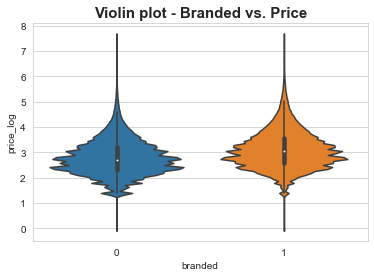

In [72]:
sns.violinplot('branded','price_log', data=df_train)
plt.title('Violin plot - Branded vs. Price', weight='bold').set_size(15)
plt.show()

__Observations:__<br>
As you can see, branded products tend to have higher price than that of non branded products.

In [73]:
# file = open('df_train_eda', 'wb')
# pickle.dump(df_train, file)
# file.close()

In [74]:
df_train.to_csv('df_eda.csv', index=False)